In [2]:
import seaborn as sns
sns.set_style("whitegrid")
from scipy.stats.mstats import mquantiles
    
#from chase.base import *
#from chase.utils import *
#from chase.fit import *
from chase.cpt import w_prelec
from chase.process_model import *
from chase.fit_process import *

# store results of fitting model
bf_par = {}
cp = {}
bf_cp = {}
quant = {}
bf_quant = {}

N_ITER = 1

problems_str = {0: '4 w/ .8\nvs. 3',
                1: '4 w/ .2\nvs. 3 w/ .25',
                2: '-3 vs.\n-32 w/ .1',
                3: '-3 vs.\n-4 w/ .8',
                4: '32 w/ .1\nvs. 3',
                5: '32 w/ .025\nvs3 w/ .25'}

FIGDEST = 'results_figures'

In [4]:
# load six problems
problems = {}
arr = np.genfromtxt('../data/six_problems.csv', delimiter=',')
for i in range(len(arr)):
    problems[i] = arr[i].reshape((2,2,2))

In [6]:
# load UCS09
trialdata_ungemach09 = pd.read_csv('../data/ungemach09/Ungemach09_sampling_134.0.txt', index_col=0, sep=" ")
choicedata_ungemach09 = pd.read_csv('../data/ungemach09/Ungemach09_choice_134.0.txt', index_col=0, sep=" ")
data_ungemach09 = trialdata_ungemach09.groupby(['subject', 'problem']).apply(lambda d: pd.Series({'samplesize': d.shape[0]})).reset_index()
data_ungemach09['choice'] = choicedata_ungemach09.sort_values(by=['subject','problem']).choice.values
data_ungemach09['problem'] = data_ungemach09['problem'] - 1

# reverse coding of choices
data_ungemach09['choice'] = np.abs(1-data_ungemach09['choice'].values)

# load HBWE04
data_hertwig04 = pd.read_csv('../data/hertwig2004/hertwig2004_data.csv', index_col=0).reset_index()

# load HPKH08 (first study only)
data_hau08 = pd.read_csv('../data/hau2008/hau_data.csv', index_col=0)
data_hau08 = data_hau08[data_hau08.group==1]

# combine
data_ungemach09['study'] = 'UCS09'
data_hertwig04['study'] = 'HBWE04'
data_hau08['study'] = 'HPKH08'
data = pd.concat((data_ungemach09, data_hertwig04, data_hau08)).reset_index()
data = data.drop(['level_0', 'index'], axis=1)
data.group = 0

In [7]:
data.groupby(['problem', 'study']).agg({'choice': np.mean, 'samplesize': np.mean}).round(decimals=2)

samplesize  choice
problem study                     
0       HBWE04       15.76    0.88
        HPKH08       10.05    0.62
        UCS09        17.96    0.64
1       HBWE04       24.84    0.44
        HPKH08       16.63    0.55
        UCS09        25.36    0.56
2       HBWE04       21.96    0.28
        HPKH08       13.97    0.11
        UCS09        21.84    0.16
3       HBWE04       27.64    0.56
        HPKH08       13.37    0.45
        UCS09        22.68    0.68
4       HBWE04       14.92    0.20
        HPKH08       13.02    0.15
        UCS09        27.12    0.08
5       HBWE04       20.32    0.12
        HPKH08       17.00    0.28
        UCS09        27.92    0.28

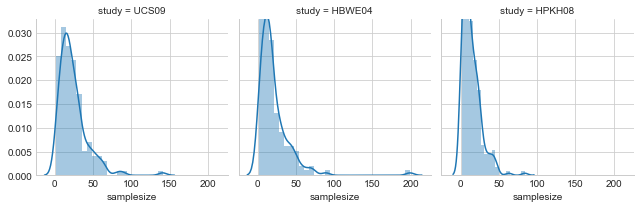

In [127]:
g = sns.FacetGrid(data, col="study", margin_titles=True)
g.map(sns.distplot, "samplesize")
plt.show()

# Fit aggregate data

In [11]:
allresults = []

PARSETS = {}
PARSETS['optional'] = [['theta', 'tau_trunc', 'c_sigma'],
                       ['theta', 'tau_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                       ]

PARSETS['geometric'] = []

In [ ]:
#for stoprule in ['optional', 'geometric']:
for stoprule in ['optional']:
    
    if stoprule == 'optional':
        SIM_ID = 'process_chapter'
        OUTDIR = 'process_fitresults_chapter'
        m = CHASEProcessModel(problems=problems,
                              stoprule='optional')
        
    elif stoprule == 'geometric':
        SIM_ID = 'process_planned_chapter'
        OUTDIR = 'process_planned_fitresults_chapter'
        m = CHASEProcessModel(problems=problems,
                              stoprule='fixedGeom')

    FIXED = {'minsamplesize': 2, 
             'max_T': 1000, 
             'N': 20000, 
             'stoprule': stoprule}

    for fitting in PARSETS[stoprule]:
        results = fit_mlh(m, problems, data, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR,
                          method='DE')

In [13]:
results = pd.DataFrame([], columns=['model', 'sim_id', 'dataset', 'stoprule', 'k', 'N', 'nllh', 'bic', 
                                    'tau', 'tau_trunc', 'tau_unif',
                                    'theta', 'p_stop_geom', 'sc', 'sc2', 'sc0', 'c', 'c_sigma', 'c_0', 
                                    'pow_gain', 'w_loss', 'prelec_elevation', 'prelec_gamma'])
    
for stoprule in ['optional', 'geometric']:
    
    if stoprule == 'optional':
        SIM_ID = 'process_chapter'
        OUTDIR = 'process_fitresults_chapter'
    elif stoprule == 'geometric':
        SIM_ID = 'process_planned_chapter'
        OUTDIR = 'process_planned_fitresults_chapter'
    FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': stoprule}

    for i, parset in enumerate(PARSETS[stoprule]):
        b = best_result(SIM_ID, FIXED, parset, outdir=OUTDIR)
        if b is not None:
            b['model'] = i
            b['dataset'] = 'HBWE04'
            b['stoprule'] = stoprule
            results.loc[results.shape[0]] = b
                
results['pars'] = results['sim_id'].apply(lambda d: d.split('|')[0].split('(', 1)[1])
allresults.append(results)
results.sort_values('bic')

,model,sim_id,dataset,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_unif,theta,p_stop_geom,sc,sc2,sc0,c,c_sigma,c_0,pow_gain,w_loss,prelec_elevation,prelec_gamma,pars
1,1,"process_chapter(c_sigma,prelec_elevation,prele...",HBWE04,optional,5,530,2341.816876,4714.998138,NaN,17.087126,NaN,43.799912,NaN,NaN,NaN,NaN,NaN,10.184548,NaN,NaN,NaN,0.968597,1.510954,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
0,0,"process_chapter(c_sigma,tau_trunc,theta|N=2000...",HBWE04,optional,3,530,2398.987072,4816.792775,NaN,50.820069,NaN,84.053618,NaN,NaN,NaN,NaN,NaN,21.089276,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau_trunc,theta"


# Fitted model predictions

In [14]:
fitting = PARSETS['optional'][1]
SIM_ID = 'process_chapter'
OUTDIR = 'process_fitresults_chapter'
m = CHASEProcessModel(problems=problems,
                      stoprule='optional')
FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': 'optional'}

best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, data, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR, N=20000)
print best

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          2341.82
k                                                                   5
N                                                                 530
bic                                                              4715
c_sigma                                                       10.1845
prelec_elevation                                             0.968597
prelec_gamma                                                  1.51095
tau_trunc                                                     17.0871
theta                                                         43.7999
sim_id              process_chapter(c_sigma,prelec_elevation,prele...
Name: 0, dtype: obje

In [15]:
# store best-fitting parameters and predictions
bf_par[SIM_ID] = best
cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = pred.groupby('problem').apply(lambda d: np.mean(d.pred_cp))

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].mean().values

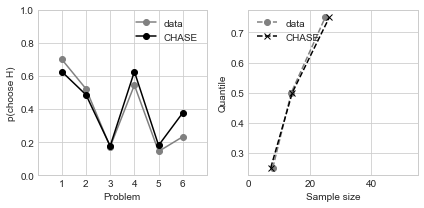

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

In [17]:
ch0 = pred[pred.problem==0].pred_cp
ch4 = pred[pred.problem==4].pred_cp
ch3 = np.abs(1 - pred[pred.problem==3].pred_cp)
ch2 = np.abs(1 - pred[pred.problem==2].pred_cp)

In [18]:
print 'Choice(%s):' % problems_str[0].replace('\n', ' '), np.round(ch0.mean(), 2)
print 'Choice(%s):' % problems_str[4].replace('\n', ' '), np.round(ch4.mean(), 2)
print 'Choice(%s):' % problems_str[3].replace('\n', ' '), np.round(ch3.mean(), 2)
print 'Choice(%s):' % problems_str[2].replace('\n', ' '), np.round(ch2.mean(), 2)
print 'Aggregate choice:', np.round(pd.concat([ch0, ch4, ch3, ch2]).mean(), 2)

Choice(4 w/ .8 vs. 3): 0.63
Choice(32 w/ .1 vs. 3): 0.18
Choice(-3 vs. -4 w/ .8): 0.37
Choice(-3 vs. -32 w/ .1): 0.82
Aggregate choice: 0.5


In [19]:
for pid in [0, 4, 3, 2]:
    print 'Sample size(%s):' % pid, np.round(pred[pred.problem==pid]['pred_ss_mean'].mean(), 2)
print 'Aggregate sample size:', np.round(pred[pred.problem.isin([0, 4, 3, 2])].pred_ss_mean.mean(), 2)

Sample size(0): 20.69
Sample size(4): 16.79
Sample size(3): 20.44
Sample size(2): 16.69
Aggregate sample size: 18.64
